## MSCNN detection test
* 实现在kitti数据集上的车辆检测，并可视化测试结果
* 从ｍａｔｌａｂ版本进行的移植
* 未完成的版本

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import caffe

In [5]:
caffe.set_mode_cpu()
model_def = caffe_root + 'examples/kitti_car/mscnn-8s-768-trainval/mscnn_deploy.prototxt'
model_weights = caffe_root + 'examples/mscnn-8s-768-trainval-pretrained/mscnn_kitti_trainval_2nd_iter_35000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)

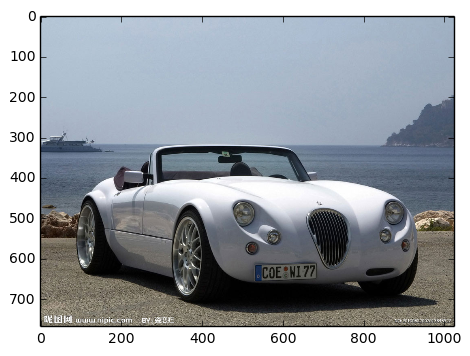

In [6]:
image = caffe.io.load_image(caffe_root + 'examples/car.jpg')
plt.imshow(image)

Let's choose the right input size.

In [32]:
from numpy.matlib import repmat

In [35]:
mu = np.ones( (1,1,3), dtype = int) 
mu[:,:,:3] = [104,117,123]
mu

array([[[104, 117, 123]]])

In [38]:
net.blobs['data'].reshape(
                          1,
                          3,
                          2560,  #using the right size of input image
                          768
                         )

In [40]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [41]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

In [ ]:
net.forward()

In [ ]:
obj_names = {'bg','car','van','truck','tram'};

Now let's take max across all windows and plot the top classes.

The top detections are in fact a person and bicycle.
Picking good localizations is a work in progress; we pick the top-scoring person and bicycle detections.

That's cool. Let's take all 'bicycle' detections and NMS them to get rid of overlapping windows.

In [7]:
def nms_detections(dets, overlap=0.3):
    """
    Non-maximum suppression: Greedily select high-scoring detections and
    skip detections that are significantly covered by a previously
    selected detection.

    This version is translated from Matlab code by Tomasz Malisiewicz,
    who sped up Pedro Felzenszwalb's code.

    Parameters
    ----------
    dets: ndarray
        each row is ['xmin', 'ymin', 'xmax', 'ymax', 'score']
    overlap: float
        minimum overlap ratio (0.3 default)

    Output
    ------
    dets: ndarray
        remaining after suppression.
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    ind = np.argsort(dets[:, 4])

    w = x2 - x1
    h = y2 - y1
    area = (w * h).astype(float)

    pick = []
    while len(ind) > 0:
        i = ind[-1]
        pick.append(i)
        ind = ind[:-1]

        xx1 = np.maximum(x1[i], x1[ind])
        yy1 = np.maximum(y1[i], y1[ind])
        xx2 = np.minimum(x2[i], x2[ind])
        yy2 = np.minimum(y2[i], y2[ind])

        w = np.maximum(0., xx2 - xx1)
        h = np.maximum(0., yy2 - yy1)

        wh = w * h
        o = wh / (area[i] + area[ind] - wh)

        ind = ind[np.nonzero(o <= overlap)[0]]

    return dets[pick, :]

In [8]:
scores = predictions_df['bicycle']
windows = df[['xmin', 'ymin', 'xmax', 'ymax']].values
dets = np.hstack((windows, scores[:, np.newaxis]))
nms_dets = nms_detections(dets)

Show top 3 NMS'd detections for 'bicycle' in the image and note the gap between the top scoring box (red) and the remaining boxes.

scores: [ 0.86610985 -0.70051557 -1.34796357]


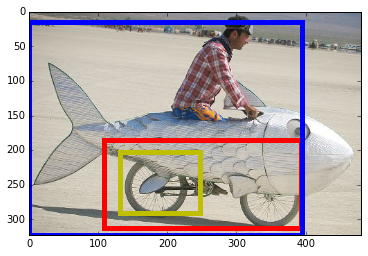

In [9]:
plt.imshow(im)
currentAxis = plt.gca()
colors = ['r', 'b', 'y']
for c, det in zip(colors, nms_dets[:3]):
    currentAxis.add_patch(
        plt.Rectangle((det[0], det[1]), det[2]-det[0], det[3]-det[1],
        fill=False, edgecolor=c, linewidth=5)
    )
print 'scores:', nms_dets[:3, 4]

This was an easy instance for bicycle as it was in the class's training set. However, the person result is a true detection since this was not in the set for that class.

You should try out detection on an image of your own next!

(Remove the temp directory to clean up, and we're done.)